In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import regex as re
import os


In [8]:
FIGRATIO = 2 / 5
FIGWIDTH = 10  # inches
FIGHEIGHT = FIGWIDTH * FIGRATIO
FIGSIZE = (FIGWIDTH, FIGHEIGHT)

plt.rcParams.update(
    {
        "axes.labelsize": 12,
        "axes.titlesize": 12,
        "figure.figsize": FIGSIZE,
        "figure.dpi": 300,
        "font.size": 12,
        "legend.fontsize": 12,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "text.usetex": True,
    }
)

COLORS = sns.color_palette("Paired")
sns.set_style("ticks")
sns.set_palette(COLORS)

# Define task names
producer_task_name = "task::MapBatches(produce_video_slices)"
consumer_task_name = "task::MapBatches(preprocess_video)"
no_parallel_task_name = "task::MapBatches(produce_video_slices)->MapBatches(preprocess_video)"
gpu_task_name = "task::MapBatches(Classifier)"

In [9]:
def plot_task_timeline_with_gpu(df, ax):
    global_start = 0
    for index, row in df.iterrows():
        if global_start == 0:
            global_start = row.name
            break

    # df = df[(df.index - global_start) / 1_000_000 >= 51]
    # Populate worker id for y coordinates
    df = df[
        (df["cat"] == producer_task_name)
        | (df["cat"] == consumer_task_name)
        | (df["cat"] == gpu_task_name)
        | (df["cat"] == no_parallel_task_name)
    ]
    unique_workers = df["tid"].unique()
    y_coordinates = {worker: index - 1 for index, worker in enumerate(unique_workers)}

    min_start = 1000
    ax.plot([0, 0], [0, 0], alpha=0)  # Note: for add_patch to work
    for index, row in df.iterrows():
        start_time = (index - global_start) / 1_000_000
        min_start = min(min_start, start_time)
        duration = row["dur"] / 1_000_000
        task_name = row["cat"]
        worker = row["tid"]
        y_coordinate = y_coordinates[worker]

        color_index = 0
        if task_name == producer_task_name or task_name == no_parallel_task_name:
            color_index = 1
        elif task_name == consumer_task_name:
            color_index = 2
        else:
            color_index = 4
        color = COLORS[color_index]

        ax.add_patch(
            plt.Rectangle(
                (start_time - min_start, y_coordinate),
                duration,
                0.5,
                fill=True,
                facecolor=color,
                edgecolor="grey",
                zorder=100,
            )
        )

    ax.set_xlabel("Time (s)", fontsize=15)
    ax.yaxis.set_visible(False)
    ax.tick_params(axis="x", labelsize=13)

In [10]:
def postprocess(logging_file):
    if not os.path.exists(logging_file):
        print(f"File {logging_file} does not exist.")
        return
    start_time_pattern = r"\[Producer Start\] (\d+\.\d+)"
    end_time_pattern = r"\[Producer End\] (\d+\.\d+)"

    start_time = None
    end_time = None

    with open(logging_file, "r") as f:
        for line in f:
            if not start_time:
                match = re.search(start_time_pattern, line)
                if match:
                    start_time = float(match.group(1))
                    print(f"Found start time: {start_time}")
            if not end_time:
                match = re.search(end_time_pattern, line)
                if match:
                    end_time = float(match.group(1))
                    print(f"Found end time: {end_time}")

    return start_time, end_time

logging_file = "/home/ubuntu/ray-data-eval/ray_data_eval/video_inference/long_video/long_video_pipeline_no_repartitioning_log.txt"
start_time, end_time = postprocess(logging_file)
dur = (end_time - start_time) * 1e6
dur

Found start time: 8557.062780947
Found end time: 8563.136849834


6074068.886999157

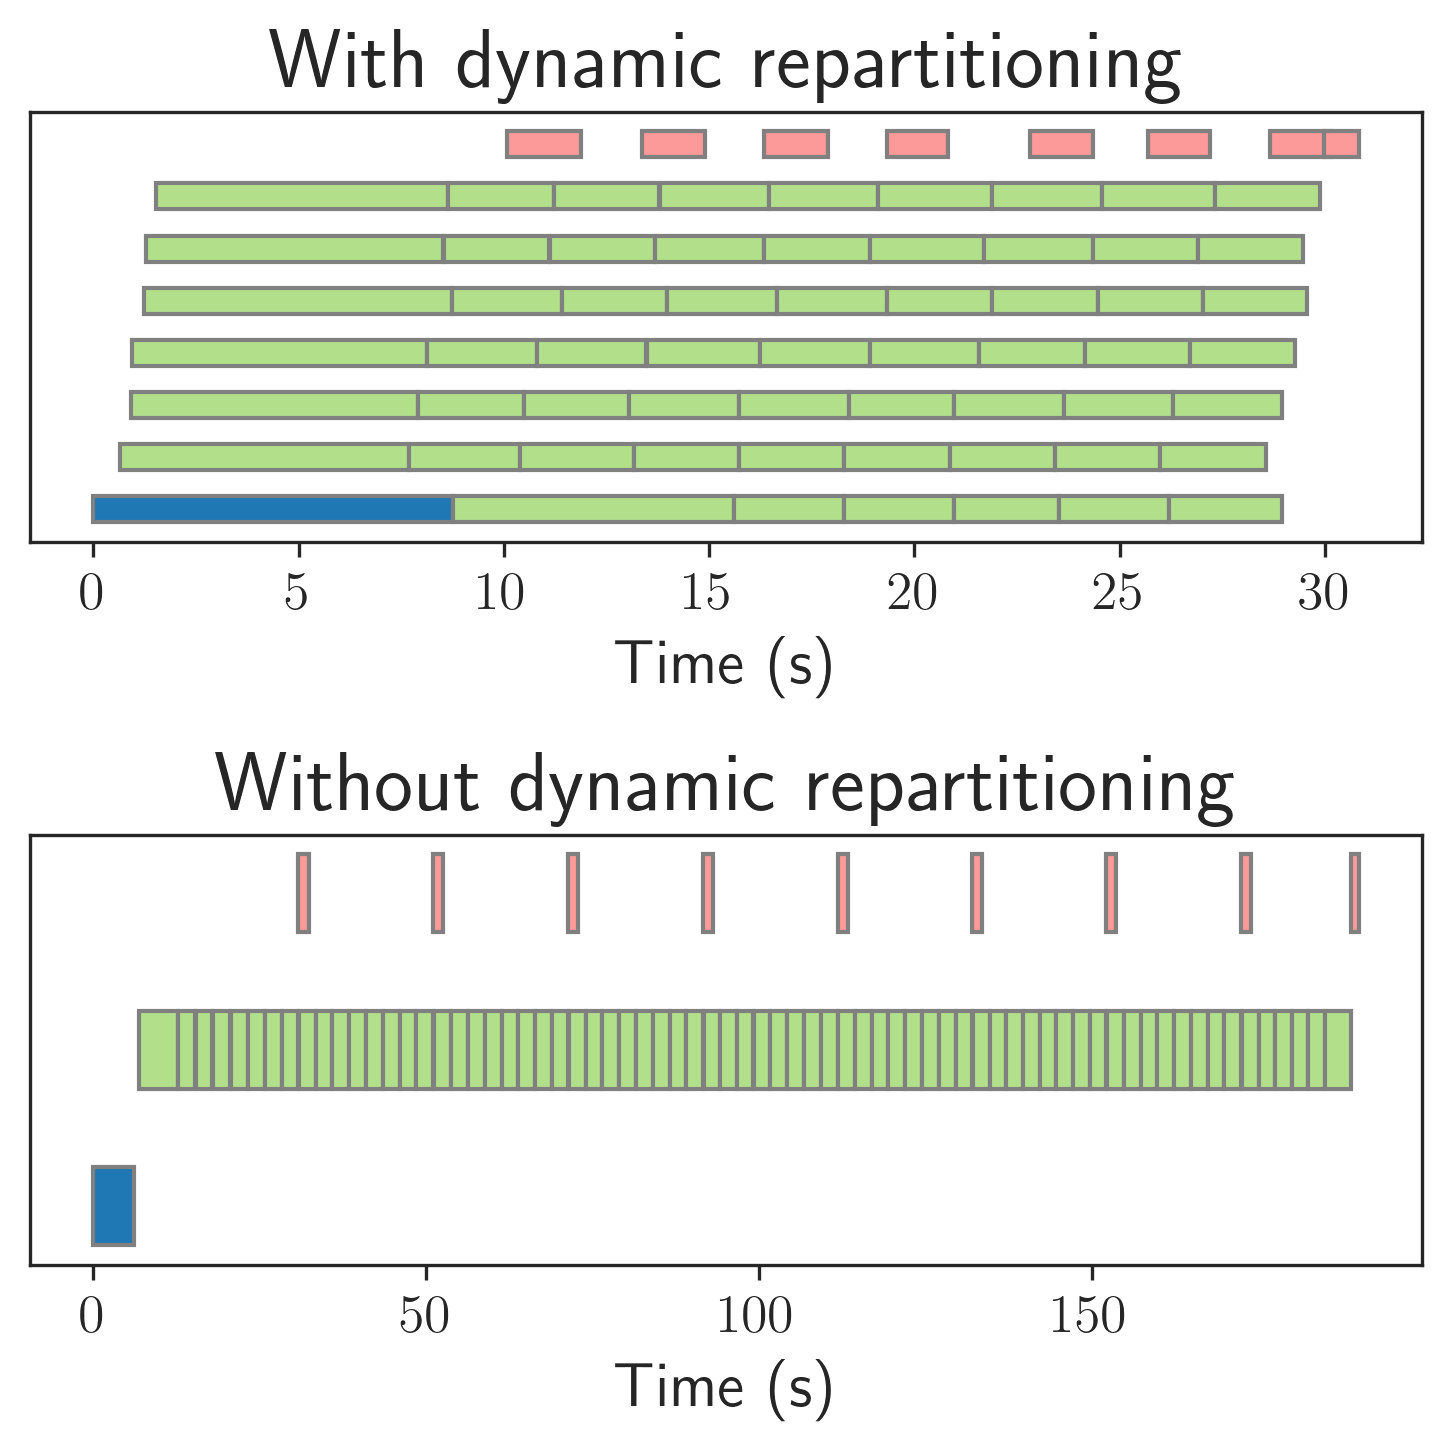

In [11]:
# Create a figure and axis
directory = "/home/ubuntu/ray-data-eval/ray_data_eval/video_inference/long_video/logs/"
file_paths = [
        "/home/ubuntu/ray-data-eval/ray_data_eval/video_inference/long_video/long_video_pipeline.json",
        "/home/ubuntu/ray-data-eval/ray_data_eval/video_inference/long_video/long_video_pipeline_no_repartitioning.json"
]

num_plots = len(file_paths)
num_cols = 1
num_rows = 2

fig, axs = plt.subplots(num_rows, num_cols, figsize=(5, 5))

for i, file_path in enumerate(file_paths):
    df = pd.read_json(file_path)
    df.set_index("ts", inplace=True)
    df.sort_index(inplace=True)
    if os.path.basename(file_path)[:-5] == "long_video_pipeline":
        axs[i].set_title("With dynamic repartitioning", fontsize=20)
    else:
        df.loc[df["cat"] == producer_task_name, "dur"] = dur
        axs[i].set_title("Without dynamic repartitioning", fontsize=20)

    plot_task_timeline_with_gpu(df, axs[i])
    file_name = os.path.basename(file_path)[:-5]

plt.tight_layout()
plt.savefig("no-repartitioning.pdf")
plt.show()